# Take Home 1
## Sarah Penrice

In [95]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import matplotlib.pyplot as plt

### Task 1
The following code integrates the information from the csv files in the "job_url_data" folder into a single dictionary with the individual URLs as keys and the earliest date at which they were scraped as values. The results are saved into a json file and the number of unique URLs from 5/17/2022-5/23/2022 are reported.

In [96]:
urls={}
#loop through every file in the folder
for filename in os.scandir('indeed_scraped_data/job_url_data'):
    if (filename.is_file()) and ('.csv' in filename.path):
    #parse the file name for date
        parsed=filename.path.split('_')
        date=parsed[8]     #files have format indeed_scraped_data/job_url_data/job_urls_for_parsehub_DATE_v#.csv
        day=date[1:2]
        #loop through every line of the csv(apart from the headers)
        with open(filename.path) as file:
            data=file.readlines()[1:] #don't include the headers
            for line in data:
                #if the url is not already in the dictionary, add it as key with the date as value
                if line not in urls:
                    urls[line]=date
                else: #replace current entry if it is an earlier date
                    if(day<urls[line][1:2]):
                        urls[line]=date

#strip white space off the URLS
stripped={}
for i in urls:
    stripped[i.strip()]=urls[i]

#save the results in a json file
with open('takehome1_url.json','w') as outfile:
    json.dump(stripped,outfile)
    
#filter by count values in between may 17-23
count=0
valid=['5172022','5182022','5192022','5202022','5212022','5222022','5232022']
for i in stripped:
    if stripped[i] in valid:
        count+=1
print(count,'URLS collected between 5/17-23/2022')

21260 URLS collected between 5/17-23/2022


### Task 2
The following code cleans the files (both csv and jscon) in the  "job_info_data" folder, dropping records with missing titles and/or descriptions, dropping duplicates and combining the results into a single dataframe. The results are saved in an updated csv and the number of unique jobs is reported.

In [97]:
dfs=[]
headers=['URL','Job Title','Company','Company URL','Company Location','Job Description']
for filename in os.scandir('indeed_scraped_data/job_info_data'):
    if filename.is_file():
        if '.csv' in filename.path:
            data=pd.read_csv(filename.path,delimiter=',')
        elif '.json' in filename.path:
            use=[]
            with open(filename.path) as file:
                data=json.load(file)
                for i in data:
                    for item in data[i]:
                        if(len(item)==6):#only include those with all 6 fields
                            use.append(item)
                data=pd.DataFrame(use)
        data.columns=headers #make headers match
        dfs.append(data)
df=pd.concat(dfs) #combine into a single dataframe

#clean based on missing values and duplicates
df=df[df["Job Title"].notnull()]
df=df[df["Job Description"].notnull()]
df=df.drop_duplicates('URL').reset_index(drop=True)
df.to_csv('takehome1_info.csv',index=False) #write cleaned data to csv

print(len(df),"unique jobs")

15574 unique jobs


### Task 3
The following code reads in the clean data and merges them based on their URLS. Merging with how='inner' takes the intersection meaning only including URLs that appear in both datasets. Depending on the order of the dataframes and operating on the intersection, we can determine the number of missing urls in each dataset. The results are interpretted below in more depth.

In [98]:
#access job url data as dataframe
with open('takehome1_url.json') as file:
    data=json.load(file)
    url=pd.DataFrame(data.items(),columns=["URL","Date"])

In [99]:
#access job info data as dataframe
info=pd.read_csv('takehome1_info.csv')

In [100]:
#merge using url
data=url.merge(info,on='URL',how="inner")
data.to_csv('combined.csv',index=False)

print('There are',len(data),'jobs found in both datasets.')

d1=url.merge(info,on='URL',how='left')
print('There are',len(d1)-len(data),'unmatched jobs in the url dataset.')

d2=info.merge(url,on='URL',how='left')
print('There are',len(d2)-len(data),'unmatched jobs in the info dataset.')

total=len(d1)+len(d2)-len(data)
print(len(data)/total*100,'percentage of jobs are found in both datasets.')

There are 15404 jobs found in both datasets.
There are 5856 unmatched jobs in the url dataset.
There are 170 unmatched jobs in the info dataset.
71.88054129724685 percentage of jobs are found in both datasets.


          URL
Date         
5172022  3189
5182022   885
5192022  4435
5202022  2929
5212022  3410
5232022   556


Text(0, 0.5, 'Number of Job Listings')

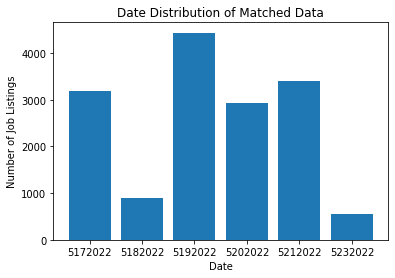

In [112]:
date_dist=data.groupby(['Date']).agg({"URL":"count"})
print(date_dist)
plt.bar(date_dist.index,date_dist["URL"])
plt.title("Date Distribution of Matched Data")
plt.xlabel('Date')
plt.ylabel('Number of Job Listings')

The above graph shows the date distribution of the URLs that appear in both data sets. We can generally observe that the most job postings are found in the middle of the given dates, 5/19-21. However, we also see a large number of postings found on 5/17. Since in processing the data, we used the first data that the URL appeared, it makes sense to have alot of data on the first day. It seems that there were few additional jobs added on the following day. 

          URL
Date         
5172022  1591
5182022    57
5192022   223
5202022    40
5212022   298
5232022  3647


Text(0, 0.5, 'Number of Job Listings')

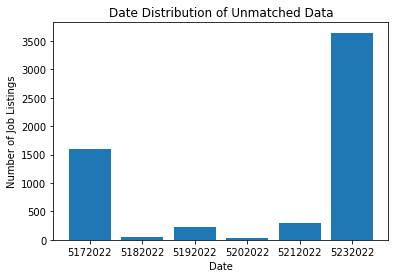

In [118]:
#missing data in url
missing_url=d1[d1['Job Description'].isnull()]
url_dist=missing_url.groupby(['Date']).agg({"URL":"count"})
print(url_dist)
plt.bar(url_dist.index,url_dist["URL"])
plt.title("Date Distribution of Unmatched Data")
plt.xlabel('Date')
plt.ylabel('Number of Job Listings')

The above bar chart shows the date distribution of the unmatched data. The largest values appear on the first and last day with very low values from 5/18-5/21

The plots of the distribution by date show that the collection methods are flawed in that a lot of the data is unmatched on the first and last day of data collection. We aim for consistently low values of unmatched data across all dates in which data was collected. By looking at the distribution of matched data we may try to reason that few new jobs were added on the last day and look for a cause where in reality, there may just be an error in how the data was collected. This type of error is especially impactful in this case since data was only collected over 6 days so it does introduce a bias.